# Modelling

In [1]:
from calibration.dataprocessing import loaddata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from airpollutionmodel import preprocessing
from airpollutionmodel.sensors import Sensor, Network
import GPy

In [2]:
# Load the data
data = preprocessing.get_data(path = '../Data/sensor_data.csv',
                              isAveraged = True,
                              window = 'hour')

In [3]:
# Convert time into number of hours from 'now'
data['hours'] = (data['time'].max() - data['time'])//pd.Timedelta(1, 'hour')

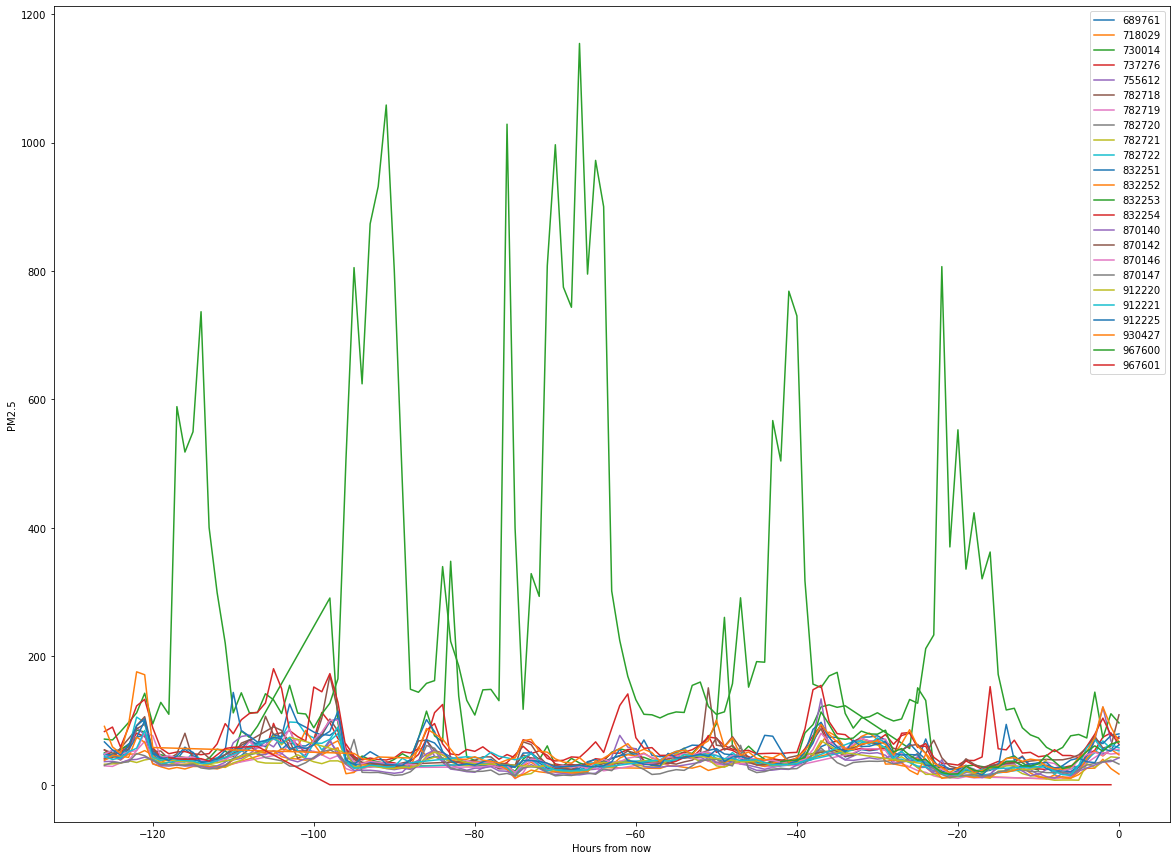

In [5]:
plt.figure(figsize = (20, 15))
for channel in data['channel_id'].unique():
    channel_data = data[data['channel_id'] == channel]
    plt.plot(-channel_data['hours'], channel_data['pm2_5'], label = channel)
plt.xlabel('Hours from now')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

In [6]:
X = data[['latitude', 'longitude', 'hours']].to_numpy()
Y = data['pm2_5'].to_numpy().reshape(-1, 1)

In [16]:
space_kern = GPy.kern.RBF(2, active_dims = [0, 1], name = 'spaceRBF')
time_kern = GPy.kern.RBF(1, active_dims = [2], name = 'timeRBF')
kern = space_kern + time_kern
model = GPy.models.GPRegression(X, Y, kern, normalizer = True)

In [18]:
model.optimize()

In [19]:
model

GP_regression.,value,constraints,priors
sum.spaceRBF.variance,0.48912122301057115,+ve,
sum.spaceRBF.lengthscale,0.018045516471205045,+ve,
sum.timeRBF.variance,0.017227499348258252,+ve,
sum.timeRBF.lengthscale,6.850328798751293,+ve,
Gaussian_noise.variance,0.5787680474416089,+ve,


## Emukit experimental design approach

In [9]:
from emukit.model_wrappers import GPyModelWrapper
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.experimental_design.acquisitions import ModelVariance
from emukit.core.acquisition import IntegratedHyperParameterAcquisition
from emukit.experimental_design import ExperimentalDesignLoop

# Borders
north = np.max(X[:, 1])
south = np.min(X[:, 1])
east = np.max(X[:, 0])
west = np.min(X[:, 0])
first = np.max(X[:, 2])
last = np.min(X[:, 2])

model_emukit = GPyModelWrapper(model)
param_space = ParameterSpace([
    ContinuousParameter('latitude', west+0.2, east),
    ContinuousParameter('longitude', south, north),
    ContinuousParameter('hours', last, first)
])

acquisition_generator = lambda model: ModelVariance(model_emukit)
model_variance = ModelVariance(model_emukit)
integrated_model_variance = IntegratedHyperParameterAcquisition(model_emukit, acquisition_generator)

exp_design = ExperimentalDesignLoop(model = model_emukit,
                                    space = param_space,
                                    acquisition = integrated_model_variance,
                                    batch_size = 1)

exp_design.get_next_points(results = [], context = {'hours': 0})

KeyboardInterrupt: 

In [20]:
def location_scores(locations, samples):
    """Returns an estimate of the average model variance over time at each location.
    
    params:
        locations: list of (lat, long) tuples describing candidate locations for a new placement
    
    returns:
        average_results: mean acquisition score at each location (array)
    """
    candidate_locations = np.array([list(pair) for pair in locations])
    times = np.random.uniform(0, 126, size = samples)
    results = np.zeros((4, 1))
    for time in times:
        candidates = np.full((4, 3), time)
        candidates[:,:-1] = candidate_locations
        vari = model_variance.evaluate(candidates)
        results += vari
        
    average_results = results/samples
    
    return average_results

In [21]:
candidate_locations = [(0.10, 32.72), (0.15, 32.25), (0.10, 32.25), (0.15, 32.72)]
location_scores(candidate_locations, 15)

array([[1915.82263264],
       [1915.82263264],
       [1915.82263264],
       [1915.82263264]])